<a target="_blank" href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/evaluation/TonicValidateEvaluators.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Tonic Validate Evaluators

This notebook has some basic usage examples of how to use [Tonic Validate](https://github.com/TonicAI/tonic_validate)'s RAGs metrics using LlamaIndex. To use these evaluators, you need to have `tonic_validate` installed, which you can install via `pip install tonic-validate`.

In [ ]:
%pip install llama-index-evaluation-tonic-validate

In [ ]:
import json

import pandas as pd
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.evaluation.tonic_validate import (
    AnswerConsistencyEvaluator,
    AnswerSimilarityEvaluator,
    AugmentationAccuracyEvaluator,
    AugmentationPrecisionEvaluator,
    RetrievalPrecisionEvaluator,
    TonicValidateEvaluator,
)

## One Question Usage Example

For this example, we have an example of a question with a reference correct answer that does not match the LLM response answer. There are two retrieved context chunks, of which one of them has the correct answer.

In [ ]:
question = "What makes Sam Altman a good founder?"
reference_answer = "He is smart and has a great force of will."
llm_answer = "He is a good founder because he is smart."
retrieved_context_list = [
    "Sam Altman is a good founder. He is very smart.",
    "What makes Sam Altman such a good founder is his great force of will.",
]

The answer similarity score is a score between 0 and 5 that scores how well the LLM answer matches the reference answer. In this case, they do not match perfectly, so the answer similarity score is not a perfect 5.

In [ ]:
answer_similarity_evaluator = AnswerSimilarityEvaluator()
score = await answer_similarity_evaluator.aevaluate(
    question,
    llm_answer,
    retrieved_context_list,
    reference_response=reference_answer,
)
score

EvaluationResult(query='What makes Sam Altman a good founder?', contexts=['Sam Altman is a good founder. He is very smart.', 'What makes Sam Altman such a good founder is his great force of will.'], response='He is a good founder because he is smart.', passing=None, feedback=None, score=4.0, pairwise_source=None, invalid_result=False, invalid_reason=None)

The answer consistency score is between 0.0 and 1.0, and measure whether the answer has information that does not appear in the retrieved context. In this case, the answer does appear in the retrieved context, so the score is 1. 

In [ ]:
answer_consistency_evaluator = AnswerConsistencyEvaluator()

score = await answer_consistency_evaluator.aevaluate(
    question, llm_answer, retrieved_context_list
)
score

EvaluationResult(query='What makes Sam Altman a good founder?', contexts=['Sam Altman is a good founder. He is very smart.', 'What makes Sam Altman such a good founder is his great force of will.'], response='He is a good founder because he is smart.', passing=None, feedback=None, score=1.0, pairwise_source=None, invalid_result=False, invalid_reason=None)

Augmentation accuracy measeures the percentage of the retrieved context that is in the answer. In this case, one of the retrieved contexts is in the answer, so this score is 0.5.

In [ ]:
augmentation_accuracy_evaluator = AugmentationAccuracyEvaluator()

score = await augmentation_accuracy_evaluator.aevaluate(
    question, llm_answer, retrieved_context_list
)
score

EvaluationResult(query='What makes Sam Altman a good founder?', contexts=['Sam Altman is a good founder. He is very smart.', 'What makes Sam Altman such a good founder is his great force of will.'], response='He is a good founder because he is smart.', passing=None, feedback=None, score=0.5, pairwise_source=None, invalid_result=False, invalid_reason=None)

Augmentation precision measures whether the relevant retrieved context makes it into the answer. Both of the retrieved contexts are relevant, but only one makes it into the answer. For that reason, this score is 0.5.

In [ ]:
augmentation_precision_evaluator = AugmentationPrecisionEvaluator()

score = await augmentation_precision_evaluator.aevaluate(
    question, llm_answer, retrieved_context_list
)
score

EvaluationResult(query='What makes Sam Altman a good founder?', contexts=['Sam Altman is a good founder. He is very smart.', 'What makes Sam Altman such a good founder is his great force of will.'], response='He is a good founder because he is smart.', passing=None, feedback=None, score=0.5, pairwise_source=None, invalid_result=False, invalid_reason=None)

Retrieval precision measures the percentage of retrieved context is relevant to answer the question. In this case, both of the retrieved contexts are relevant to answer the question, so the score is 1.0.

In [ ]:
retrieval_precision_evaluator = RetrievalPrecisionEvaluator()

score = await retrieval_precision_evaluator.aevaluate(
    question, llm_answer, retrieved_context_list
)
score

EvaluationResult(query='What makes Sam Altman a good founder?', contexts=['Sam Altman is a good founder. He is very smart.', 'What makes Sam Altman such a good founder is his great force of will.'], response='He is a good founder because he is smart.', passing=None, feedback=None, score=1.0, pairwise_source=None, invalid_result=False, invalid_reason=None)

The `TonicValidateEvaluator` can calculate all of Tonic Validate's metrics at once.

In [ ]:
tonic_validate_evaluator = TonicValidateEvaluator()

scores = await tonic_validate_evaluator.aevaluate(
    question,
    llm_answer,
    retrieved_context_list,
    reference_response=reference_answer,
)

In [ ]:
scores.score_dict

{'answer_consistency': 1.0,
 'answer_similarity': 4.0,
 'augmentation_accuracy': 0.5,
 'augmentation_precision': 0.5,
 'retrieval_precision': 1.0}

You can also evaluate more than one query and response at once using `TonicValidateEvaluator`, and return a `tonic_validate` `Run` object that can be logged to the Tonic Validate UI (validate.tonic.ai).

To do this, you put the questions, LLM answers, retrieved context lists, and reference answers into lists and cal `evaluate_run`.

In [ ]:
tonic_validate_evaluator = TonicValidateEvaluator()

scores = await tonic_validate_evaluator.aevaluate_run(
    [question], [llm_answer], [retrieved_context_list], [reference_answer]
)
scores.run_data[0].scores

{'answer_consistency': 1.0,
 'answer_similarity': 3.0,
 'augmentation_accuracy': 0.5,
 'augmentation_precision': 0.5,
 'retrieval_precision': 1.0}

## Labelled RAG Dataset Example

Let's use the dataset `EvaluatingLlmSurveyPaperDataset` and evaluate the default LlamaIndex RAG system using Tonic Validate's answer similarity score. `EvaluatingLlmSurveyPaperDataset` is a `LabelledRagDataset`, so it contains reference correct answers for each question. The dataset contains 276 questions and reference answers about the paper *Evaluating Large Language Models: A Comprehensive Survey*.

We'll use `TonicValidateEvaluator` with the answer similarity score metric to evaluate the responses from the default RAG system on this dataset.

In [ ]:
!llamaindex-cli download-llamadataset EvaluatingLlmSurveyPaperDataset --download-dir ./data
from llama_index.core import SimpleDirectoryReader

from llama_index.core.llama_dataset import LabelledRagDataset

from llama_index.core import VectorStoreIndex


rag_dataset = LabelledRagDataset.from_json("./data/rag_dataset.json")

documents = SimpleDirectoryReader(input_dir="./data/source_files").load_data(
    num_workers=4
)  # parallel loading

index = VectorStoreIndex.from_documents(documents=documents)

query_engine = index.as_query_engine()

predictions_dataset = rag_dataset.make_predictions_with(query_engine)

questions, retrieved_context_lists, reference_answers, llm_answers = zip(
    *[
        (e.query, e.reference_contexts, e.reference_answer, p.response)
        for e, p in zip(rag_dataset.examples, predictions_dataset.predictions)
    ]
)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]
Successfully downloaded EvaluatingLlmSurveyPaperDataset to ./data


In [ ]:
from tonic_validate.metrics import AnswerSimilarityMetric

tonic_validate_evaluator = TonicValidateEvaluator(
    metrics=[AnswerSimilarityMetric()], model_evaluator="gpt-4-1106-preview"
)

scores = await tonic_validate_evaluator.aevaluate_run(
    questions, retrieved_context_lists, reference_answers, llm_answers
)

The `overall_scores` gives the average score over the 276 questions in the dataset.

In [ ]:
scores.overall_scores

{'answer_similarity': 2.2644927536231885}

Using `pandas` and `matplotlib`, we can plot a histogram of the similarity scores.

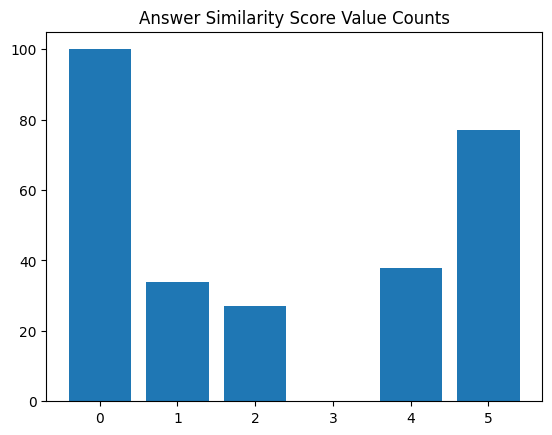

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

score_list = [x.scores["answer_similarity"] for x in scores.run_data]
value_counts = pd.Series(score_list).value_counts()

fig, ax = plt.subplots()
ax.bar(list(value_counts.index), list(value_counts))
ax.set_title("Answer Similarity Score Value Counts")
plt.show()

As 0 is the most common score, there is much room for improvement. This makes sense, as we are using the default parameters. We could imrpove these results by tuning the many possible RAG parameters to optimize this score.